## class MDP

Specifies : 

$$
(S,A,\mathbf{P},r,\nu,\gamma)
$$

where :
| Term                          | Notation                                         | Notes                                   |
|:----------------------------- |:------------------------------------------------ |:--------------------------------------- |
| Finite state space            | $S$                                              | $\lvert S \lvert=n$                     |
| Finite action space           | $A$                                              | $\lvert A \lvert = m$                   |
| Markovian transition law      | $\mathbf{P} : S \times A \rightarrow \Delta_S$ | maps onto the state probability simplex |
| Initial state distribution    | $\nu \in \Delta_S$                               |                                         |
| Reward vector                 | $r \in \mathbb{R}^{n \times m}$                  |                                         |
| Discount Factor               | $\gamma \in (0,1)$                               |                                         |

(see implementation in the env.mdp file)
		

## class Gridworld 
- should take as ijnput world size
- should provide a plot function
- be seedable
- have a step(a) method that returns an observation ???
- provide the vector-form variables used in analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rd
import jax
import jax.numpy as jnp
from env.mdp import Sampler
from env.gridworld import Gridworld, gridplot
from env.complete import Complete
from algs.dynprog import ValueIterator, PolicyIterator
from algs.projs import euclidean_l1ball, euclidean_simplex, euclidian_pos_orthant
from algs.lps import PrimalLP, DualLP
import scipy.optimize as opt
from einops import rearrange

## Instanciating the environment

In [2]:
MDP = Gridworld(
    grid_width  = 5, 
    grid_height = 5, 
    noise       = 0.2, 
    gamma       = 0.8, 
    goals       = [((2,3),2.0) ],
    obstacles   = [] #unconstrained
)

#### Plotting the markov transition probability function for a bunch of situations

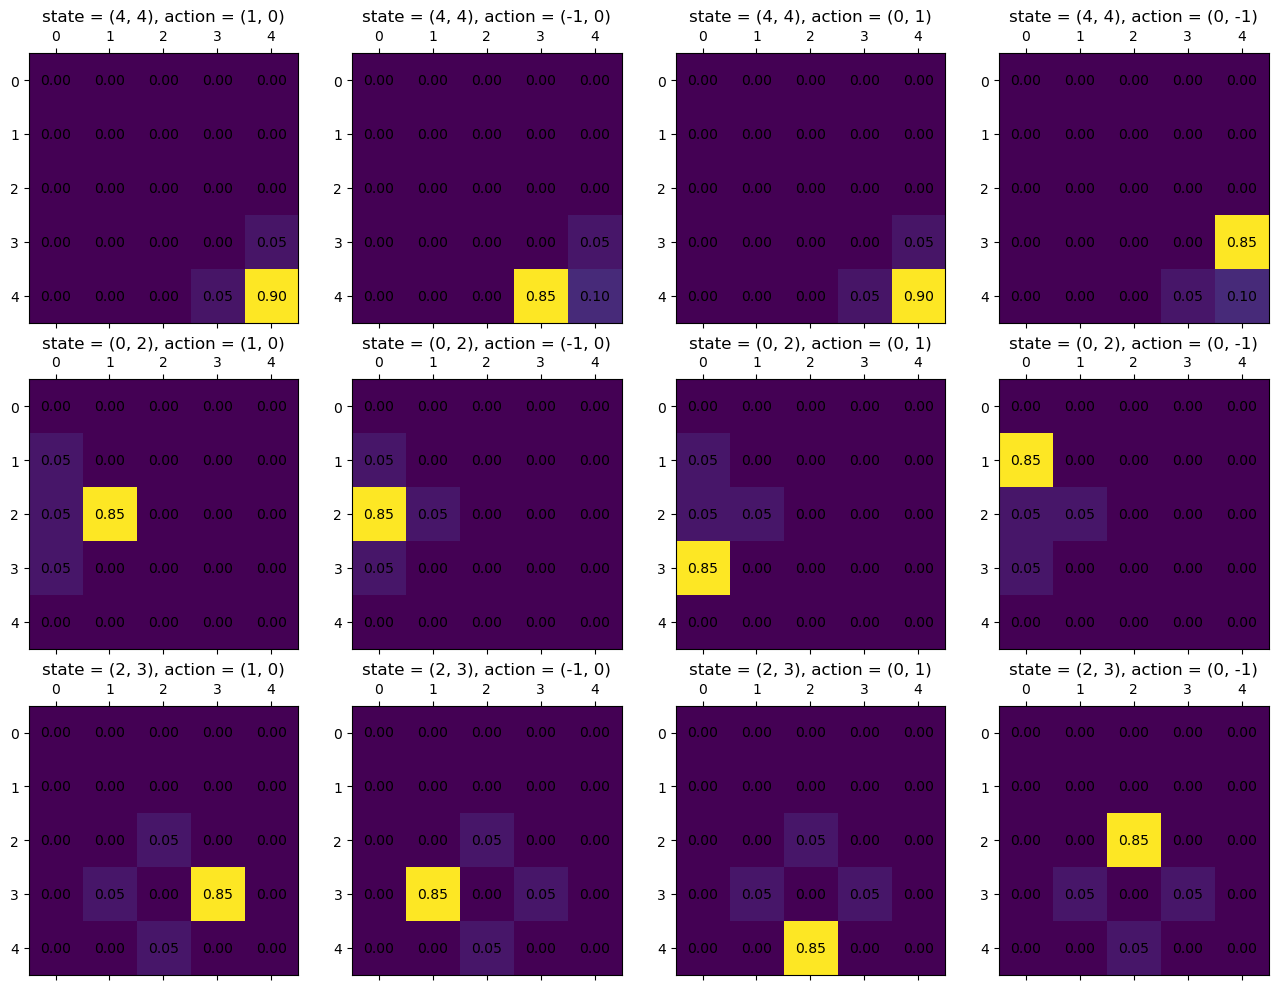

In [3]:
points = [(4,4),(0,2),(2,3)]
size = 4.
point = (2,2)
action = 3

fig, axs = plt.subplots(3,4,figsize=(4*size,3*size))
for p_id, point in enumerate(points):
    for action in range(4):
        gridprob = MDP.states2grid(MDP.next_state_distribution(MDP.point2state(point),action))
        ax = axs[p_id,action]
        ax.matshow(gridprob)
        ax.set_title(f'state = {point}, action = {MDP.actions[action]}')
        for (i, j), z in np.ndenumerate(gridprob):
            ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

plt.show()

#### Plotting the reward function for a bunch of situations

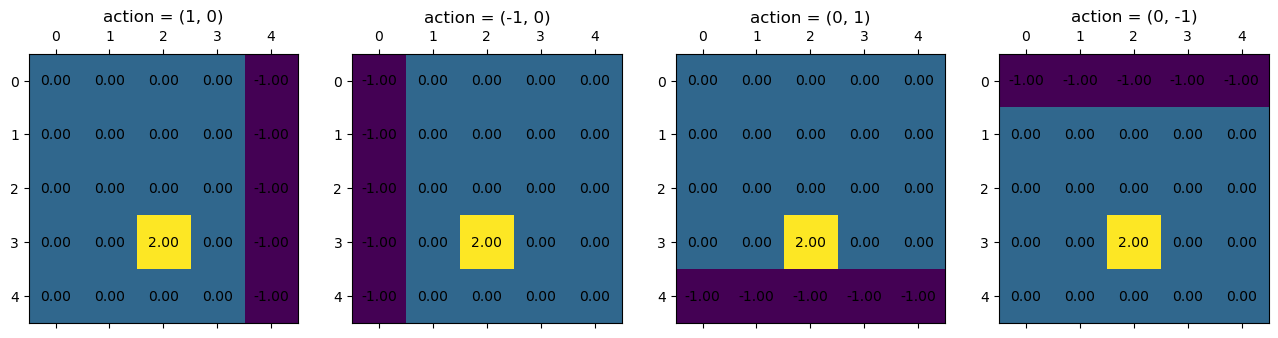

In [4]:
size = 4.
point = (2,2)
action = 3

fig, axs = plt.subplots(1,4,figsize=(4*size,1*size))

for action in range(4):
    gridreward = MDP.states2grid(MDP.R[:,action])
    ax = axs[action]
    ax.matshow(gridreward)
    ax.set_title(f'action = {MDP.actions[action]}')
    for (i, j), z in np.ndenumerate(gridreward):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
# fig.suptitle('Rewards')
plt.show()

## Dynamic Progamming methods 

#### Value Iteration

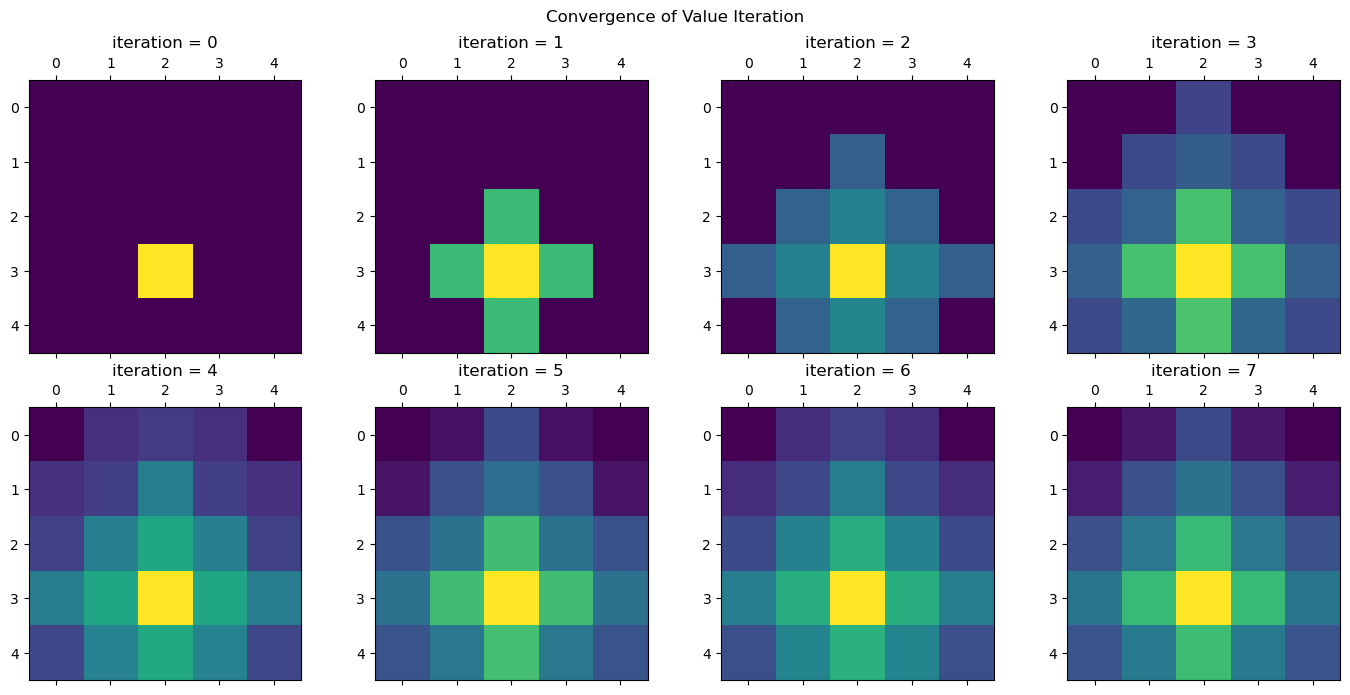

In [5]:
VI = ValueIterator(MDP)
valgrids = []
for i in range(8):
    VI.solve(1)
    valgrids += [MDP.states2grid(VI.V_t)]

sz = 7
fig, ax = plt.subplots(2,4,figsize=(2*sz,sz))
for i in range(8):
    ax[i//4,i%4].matshow(valgrids[i])
    ax[i//4,i%4].set_title(f'iteration = {i}')
fig.suptitle('Convergence of Value Iteration')
fig.tight_layout()
plt.show()

##### Recovering the policy from VI

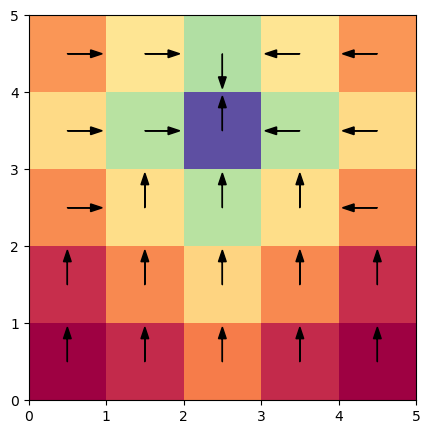

In [6]:
pi = VI.recover_policy()
fig, ax = plt.subplots(1,1,figsize=(5.,5.))
gridplot(VI.MDP,ax,scalar=VI.V_t,policy=pi)

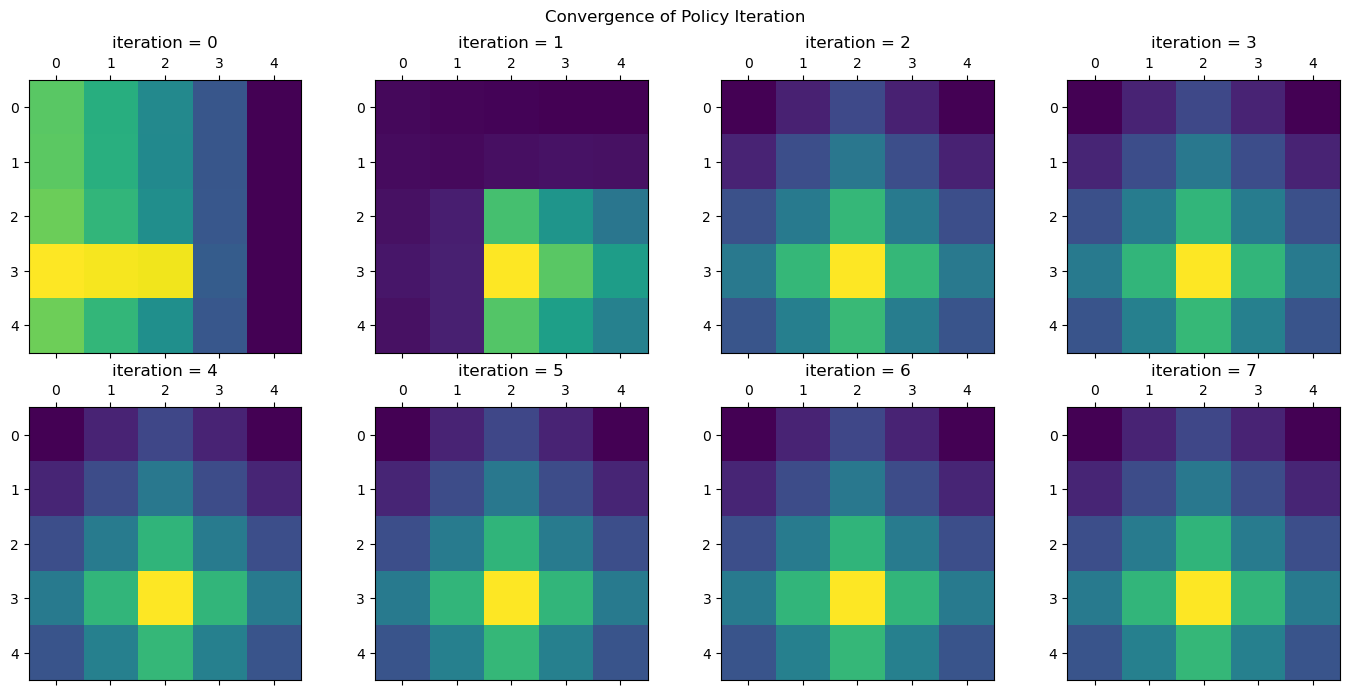

In [7]:
PI = PolicyIterator(MDP)
valgrids = []
for i in range(8):
    PI.solve(1,10)
    valgrids += [MDP.states2grid(PI.V_t)]

sz = 7
fig, ax = plt.subplots(2,4,figsize=(2*sz,sz))
for i in range(8):
    ax[i//4,i%4].matshow(valgrids[i])
    ax[i//4,i%4].set_title(f'iteration = {i}')
fig.suptitle('Convergence of Policy Iteration')
fig.tight_layout()
plt.show()

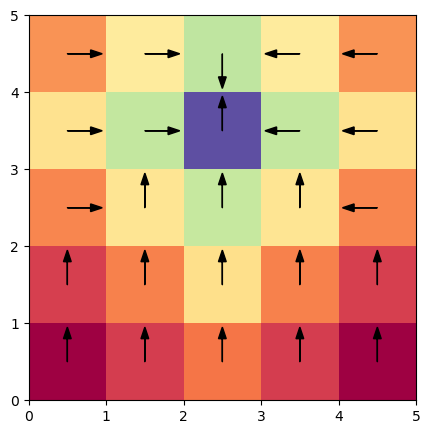

In [8]:
pi = PI.pi_t
fig, ax = plt.subplots(1,1,figsize=(5.,5.))
gridplot(PI.MDP,ax,scalar=PI.V_t,policy=pi)

### Linear programming solution to MDPs
When formulating the LP we use the convention :
$$
\begin{aligned}
r = [r(s_1,a_1),r(s_2,a_1),...,r(s_1,a_2),r(s_2,a_1),...,r(s_n,a_m)]^T, \\
\end{aligned}
$$
which implies we define the $E$ "*operator*" as follows:
$$
E = [\overbrace{I_n,I_n,....}^{\times m}]^T = 
\begin{bmatrix}
1 & 0 & ... & 0\\
0 & 1 & ... & 0\\
\vdots & \vdots & \ddots & \vdots\\
1 & 0 & ... & 0\\
0 & 1 & ... & 0\\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & ... & 1\\
\end{bmatrix},
$$
and the $P$ "*function*" as :
$$
E = [\overbrace{P^{\pi=a_1},P^{\pi=a_2},....}^{\times m}]^T = 
\begin{bmatrix}
p(s_1|s_1,a_1) & p(s_2|s_1,a_1) & ... & p(s_n|s_1,a_1)\\
p(s_2|s_2,a_1) & p(s_2|s_2,a_1) & ... & p(s_n|s_2,a_1)\\
\vdots & \vdots & \ddots & \vdots\\
p(s_1|s_1,a_2) & p(s_2|s_1,a_2) & ... & p(s_n|s_1,a_2)\\
p(s_2|s_2,a_2) & p(s_2|s_2,a_2) & ... & p(s_n|s_2,a_2)\\
\vdots & \vdots & \ddots & \vdots\\
p(s_1|s_n,a_m) & p(s_2|s_n,a_m) & ... & p(s_n|s_n,a_m)
\end{bmatrix}.
$$

Which enables us to write the *primal* $(P)$ as :
$$
\begin{aligned}
\min_V && (1-\gamma) \langle \nu, V \rangle\\
\text{s.t} && (E-\gamma P) V \geq r
\end{aligned}
$$,

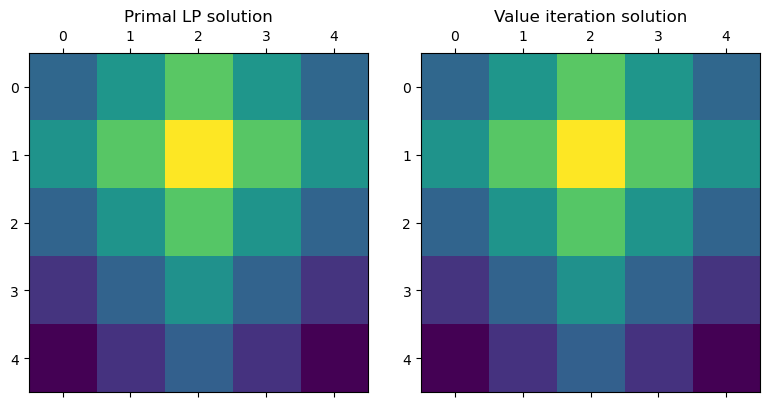

In [9]:
"""Defining a gridworld MPD"""
MDP = Gridworld(grid_width=5,grid_height=5,goals=[((2,1),4)])

"""Solving with the primal"""
primal = PrimalLP(MDP)
v_primal = primal.solve() 

"""Solving with value iteration"""
valiter = ValueIterator(MDP)
v_iter = valiter.solve(1000)

sz = 4
fig, ax = plt.subplots(1,2,figsize=(2*sz,sz))
ax[0].set_title('Primal LP solution')
ax[0].matshow(MDP.states2grid(v_primal))
ax[1].set_title('Value iteration solution')
ax[1].matshow(MDP.states2grid(v_iter))
fig.tight_layout()
plt.show()

### Dual Formulation

The *dual* $(D)$ of LP $(P)$ is expressed as :
$$
\begin{aligned}
\max_\mu && \langle \mu, r \rangle\\
\text{s.t} && (E^T-\gamma P^T) \mu = (1-\gamma) \nu\\
 && \mu \geq 0 
\end{aligned}
$$,

/Users/renard/Documents/etudes/EPFLMaster/Project/experiments/algs/lps.py:53: RuntimeWarning: divide by zero encountered in divide
  T = np.einsum('ij,i->ij',self.mu_opt,1/np.sum(self.mu_opt,1))


Text(0.5, 0.98, '(D) solution to the MDP')

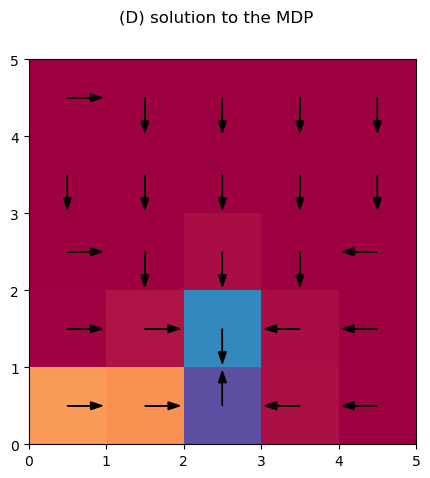

In [10]:
dual = DualLP(MDP)
mu_sa = dual.solve()
mu_s = np.sum(mu_sa,1)
sz = 5.
pi = dual.recover_policy()
fig, ax = plt.subplots(1,1,figsize=(sz,sz))
gridplot(MDP,ax,scalar=mu_s,policy=pi)
fig.suptitle('(D) solution to the MDP')

### Sampling from MDPs

We now introduce the sampler object that allows for generating trajectories $\tau$ from a known MDP

[((0, 0), 2, 0), ((0, 1), 2, 0.0), ((0, 2), 0, 0.0), ((1, 2), 2, 0.0), ((1, 3), 0, 0.0), ((1, 4), 0, 0.0)]


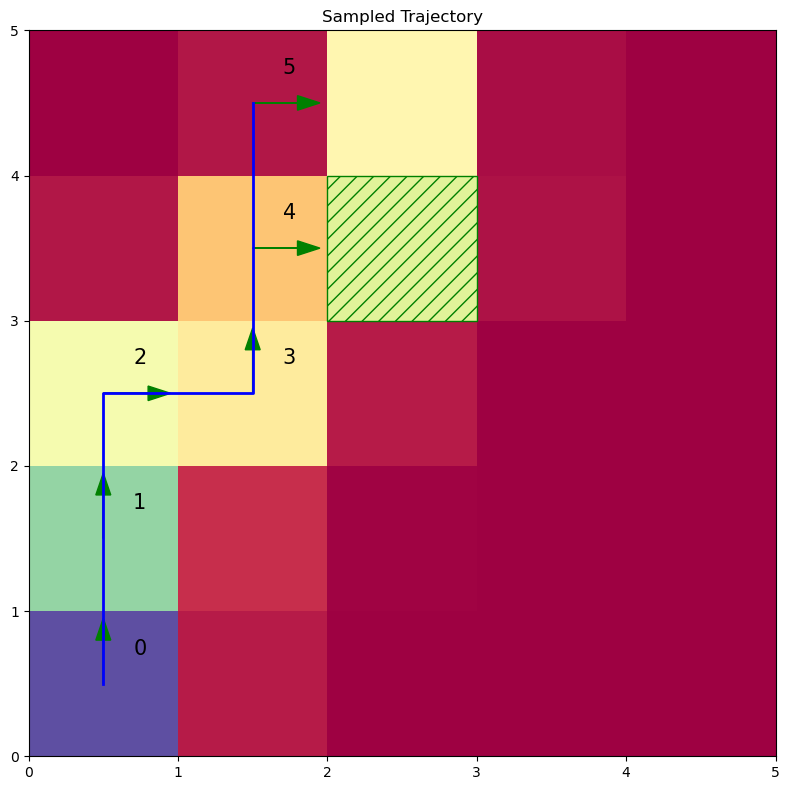

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rd
import jax
import jax.numpy as jnp
from env.mdp import Sampler
from env.gridworld import Gridworld, gridplot
from env.complete import Complete
from algs.dynprog import ValueIterator, PolicyIterator
from algs.projs import euclidean_l1ball, euclidean_simplex, euclidian_pos_orthant
from algs.lps import PrimalLP, DualLP
import scipy.optimize as opt
from einops import rearrange
goals = [((2,3),2.0) ]
MDP = Gridworld(
    grid_width  = 5, 
    grid_height = 5, 
    noise       = 0.2, 
    gamma       = 0.8, 
    goals       = goals,
    obstacles   = [] #unconstrained
)

smp = Sampler(MDP)
dual = DualLP(MDP)
mu_sa = dual.solve()
mu_s = np.sum(mu_sa,1)
pi = dual.recover_policy()

""" Get the initial state """
traj = []
r_t = 0
s_t = smp.reset()
for i in range(6):
    a_t = pi[s_t]
    traj += [(MDP.state2point(s_t),a_t,r_t)]
    s_t, r_t = smp.step(pi[s_t])

print(traj)
s_t = smp.reset()

fig, ax = plt.subplots(1,1,figsize=(8,8))
gridplot(MDP, ax, scalar=mu_s, traj=traj, goals=goals)
ax.set_title('Sampled Trajectory')
fig.tight_layout()
plt.show()